In [1]:
%matplotlib inline

## draw3d.py

In [2]:
from math import sqrt, pi
import matplotlib
import os
from matplotlib.patches import Polygon, FancyArrowPatch
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, proj3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

blue = 'C0'
black = 'k'
red = 'C3'
green = 'C2'
purple = 'C4'
orange = 'C2'
gray = 'gray'


## https://stackoverflow.com/a/22867877/1704140
class FancyArrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)


class Polygon3D():
    def __init__(self, *vertices, color=blue):
        self.vertices = vertices
        self.color = color

class Points3D():
    def __init__(self, *vectors, color=black):
        self.vectors = list(vectors)
        self.color = color

class Arrow3D():
    def __init__(self, tip, tail=(0,0,0), color=red):
        self.tip = tip
        self.tail = tail
        self.color = color

class Segment3D():
    def __init__(self, start_point, end_point, color=blue, linestyle='solid'):
        self.start_point = start_point
        self.end_point = end_point
        self.color = color
        self.linestyle = linestyle

class Box3D():
    def __init__(self, *vector):
        self.vector = vector

# helper function to extract all the vectors from a list of objects
def extract_vectors_3D(objects):
    for object in objects:
        if type(object) == Polygon3D:
            for v in object.vertices:
                yield v
        elif type(object) == Points3D:
            for v in object.vectors:
                yield v
        elif type(object) == Arrow3D:
            yield object.tip
            yield object.tail
        elif type(object) == Segment3D:
            yield object.start_point
            yield object.end_point
        elif type(object) == Box3D:
            yield object.vector
        else:
            raise TypeError("Unrecognized object: {}".format(object))

def draw3d(*objects, origin=True, axes=True, width=6, save_as=None, 
           azim=None, elev=None, xlim=None, ylim=None, zlim=None, 
           xticks=None, yticks=None, zticks=None,depthshade=False):

    fig = plt.gcf()
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev,azim=azim)
    
    all_vectors = list(extract_vectors_3D(objects))
    if origin:
        all_vectors.append((0,0,0))
    xs, ys, zs = zip(*all_vectors)

    max_x, min_x = max(0,*xs), min(0,*xs)
    max_y, min_y = max(0,*ys), min(0,*ys)
    max_z, min_z = max(0,*zs), min(0,*zs)

    x_size = max_x-min_x
    y_size = max_y-min_y
    z_size = max_z-min_z

    padding_x = 0.05 * x_size if x_size else 1
    padding_y = 0.05 * y_size if y_size else 1
    padding_z = 0.05 * z_size if z_size else 1

    plot_x_range = (min(min_x - padding_x,-2), max(max_x + padding_x,2))
    plot_y_range = (min(min_y - padding_y,-2), max(max_y + padding_y,2))
    plot_z_range = (min(min_z - padding_z,-2), max(max_z + padding_z,2))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    def draw_segment(start, end, color=black, linestyle='solid'):
        xs, ys, zs = [[start[i],end[i]] for i in range(0,3)]
        ax.plot(xs, ys, zs, color=color, linestyle=linestyle)

    if axes:
        draw_segment((plot_x_range[0],0,0), (plot_x_range[1],0,0))
        draw_segment((0,plot_y_range[0],0), (0,plot_y_range[1],0))
        draw_segment((0,0,plot_z_range[0]), (0,0,plot_z_range[1]))

    if origin:
        ax.scatter([0],[0],[0], color='k', marker='x')

    for object in objects:
        if type(object) == Points3D:
            xs, ys, zs = zip(*object.vectors)
            ax.scatter(xs,ys,zs,color=object.color,depthshade=depthshade)

        elif type(object) == Polygon3D:
            for i in range(0,len(object.vertices)):
                draw_segment(
                    object.vertices[i],
                    object.vertices[(i+1)%len(object.vertices)],
                    color=object.color)

        elif type(object) == Arrow3D:
            xs, ys, zs = zip(object.tail, object.tip)
            a = FancyArrow3D(xs,ys,zs, mutation_scale=20,arrowstyle='-|>', color=object.color)
            ax.add_artist(a)

        elif type(object) == Segment3D:
            draw_segment(object.start_point, object.end_point, color=object.color, linestyle=object.linestyle)

        elif type(object) == Box3D:
            x,y,z = object.vector
            kwargs = {'linestyle':'dashed', 'color':'gray'}
            draw_segment((0,y,0),(x,y,0),**kwargs)
            draw_segment((0,0,z),(0,y,z),**kwargs)
            draw_segment((0,0,z),(x,0,z),**kwargs)
            draw_segment((0,y,0),(0,y,z),**kwargs)
            draw_segment((x,0,0),(x,y,0),**kwargs)
            draw_segment((x,0,0),(x,0,z),**kwargs)
            draw_segment((0,y,z),(x,y,z),**kwargs)
            draw_segment((x,0,z),(x,y,z),**kwargs)
            draw_segment((x,y,0),(x,y,z),**kwargs)
        else:
            raise TypeError("Unrecognized object: {}".format(object))

    if xlim and ylim and zlim:
        plt.xlim(*xlim)
        plt.ylim(*ylim)
        ax.set_zlim(*zlim)
    if xticks and yticks and zticks:
        plt.xticks(xticks)
        plt.yticks(yticks)
        ax.set_zticks(zticks)
        
    if save_as:
        plt.savefig(save_as)

    plt.show()

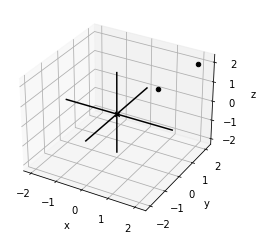

In [3]:
draw3d(Points3D((2,2,2),(1,1,1)))

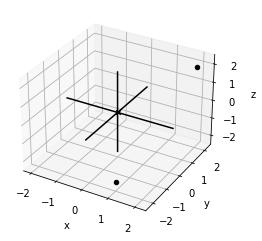

In [4]:
draw3d(
Points3D((2,2,2),(1,-2,-2))
)

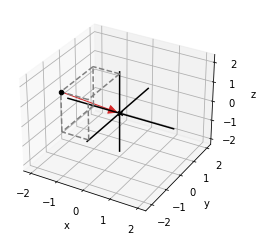

In [5]:
draw3d(
Points3D((-1,-2,2)),
Arrow3D((0,0,0),(-1,-2,2)),
Box3D(-1,-2,2)
)

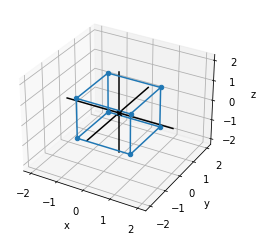

In [6]:
pm1 = [1,-1]
vertices = [(x,y,z) for x in pm1 for y in pm1 for z in pm1]
edges = [((-1,y,z),(1,y,z)) for y in pm1 for z in pm1] +\
[((x,-1,z),(x,1,z)) for x in pm1 for z in pm1] +\
[((x,y,-1),(x,y,1)) for x in pm1 for y in pm1]

draw3d(
Points3D(*vertices,color=blue),
*[Segment3D(*edge) for edge in edges]
)

In [7]:
edges

[((-1, 1, 1), (1, 1, 1)),
 ((-1, 1, -1), (1, 1, -1)),
 ((-1, -1, 1), (1, -1, 1)),
 ((-1, -1, -1), (1, -1, -1)),
 ((1, -1, 1), (1, 1, 1)),
 ((1, -1, -1), (1, 1, -1)),
 ((-1, -1, 1), (-1, 1, 1)),
 ((-1, -1, -1), (-1, 1, -1)),
 ((1, 1, -1), (1, 1, 1)),
 ((1, -1, -1), (1, -1, 1)),
 ((-1, 1, -1), (-1, 1, 1)),
 ((-1, -1, -1), (-1, -1, 1))]

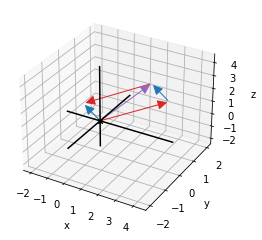

In [8]:
draw3d(
Arrow3D((4,0,3),color=red),
Arrow3D((-1,0,1),color=blue),
Arrow3D((3,0,4),(4,0,3),color=blue),
Arrow3D((-1,0,1),(3,0,4),color=red),
Arrow3D((3,0,4),color=purple)
)

(-4.440892098500626e-16, -7.771561172376096e-16, 7.9999999999999964)


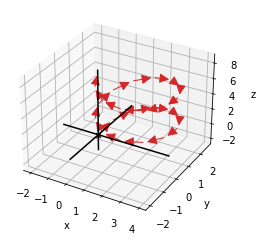

In [9]:
from vectors import *
from math import sin, cos, pi
vs = [(sin(pi*t/6), cos(pi*t/6), 1.0/3) for t in range(0,24)]
running_sum = (0,0,0) #

arrows = []
for v in vs:
    next_sum = add(running_sum, v) 
    arrows.append(Arrow3D(next_sum, running_sum))
    running_sum = next_sum
print(running_sum)
draw3d(*arrows)

In [10]:
dot((1,0),(0,2))

0

In [11]:
dot((0,3,0),(0,0,-5))

0

In [12]:
dot(scale(2,(3,4)),(2,3))

36

In [16]:
octahedron = [
    [(1,0,0), (0,1,0), (0,0,1)],
    [(1,0,0), (0,0,-1), (0,1,0)],
    [(1,0,0), (0,0,1), (0,-1,0)],
    [(1,0,0), (0,-1,0), (0,0,-1)],
    [(-1,0,0), (0,0,1), (0,1,0)],
    [(-1,0,0), (0,1,0), (0,0,-1)],
    [(-1,0,0), (0,-1,0), (0,0,1)],
    [(-1,0,0), (0,0,-1), (0,-1,0)],
]

In [13]:
blues = matplotlib.cm.get_cmap('Blues')

In [53]:
from vectors import *
from draw2d import *

def vertices(faces):
    return list(set([vertex for face in faces for vertex in face]))
def component(v,direction):
    return (dot(v,direction) / length(direction))
def vector_to_2d(v):
    return (component(v,(1,0,0)), component(v,(0,1,0)))
def face_to_2d(face):
    return [vector_to_2d(vertex) for vertex in face]


def unit(v):
    return scale(1./length(v), v)
def normal(face):
    return(cross(subtract(face[1], face[0]), subtract(face[2], face[0])))

def draw2d(*objects, origin=True, axes=True, grid=(1,1), nice_aspect_ratio=True,
            width=6, save_as=None):

    all_vectors = list(extract_vectors_2d(objects))
    xs, ys = zip(*all_vectors)

    max_x, max_y, min_x, min_y = max(0,*xs), max(0,*ys), min(0,*xs), min(0,*ys)

    #sizing
    if grid:
        x_padding = max(ceil(0.05*(max_x-min_x)), grid[0])
        y_padding = max(ceil(0.05*(max_y-min_y)), grid[1])

        def round_up_to_multiple(val,size):
            return floor((val + size) / size) * size

        def round_down_to_multiple(val,size):
            return -floor((-val - size) / size) * size

        plt.xlim(floor((min_x - x_padding) / grid[0]) * grid[0],
                ceil((max_x + x_padding) / grid[0]) * grid[0])
        plt.ylim(floor((min_y - y_padding) / grid[1]) * grid[1],
                ceil((max_y + y_padding) / grid[1]) * grid[1])
    else:
        x_padding = 0.05 * (max_x-min_x)
        y_padding = 0.05 * (max_y-min_y)

        plt.xlim(min_x-x_padding,max_x+x_padding)
        plt.ylim(min_y-y_padding,max_y+y_padding)

    if origin:
        plt.scatter([0],[0], color='k', marker='x')

    if grid:
        plt.gca().set_xticks(np.arange(plt.xlim()[0],plt.xlim()[1],grid[0]))
        plt.gca().set_yticks(np.arange(plt.ylim()[0],plt.ylim()[1],grid[1]))
        plt.grid(True)
        plt.gca().set_axisbelow(True)

    if axes:
        plt.gca().axhline(linewidth=2, color='k')
        plt.gca().axvline(linewidth=2, color='k')

    for object in objects:
        if type(object) == Polygon2D:
            if object.color:
                for i in range(0,len(object.vertices)):
                    x1, y1 = object.vertices[i]
                    x2, y2 = object.vertices[(i+1)%len(object.vertices)]
                    plt.plot([x1,x2],[y1,y2], color=object.color, lw=0)
            if object.fill:
                patches = []
                poly = Polygon(object.vertices, True)
                patches.append(poly)
                p = PatchCollection(patches, color=object.fill)
                plt.gca().add_collection(p)
        elif type(object) == Points2D:
            xs = [v[0] for v in object.vectors]
            ys = [v[1] for v in object.vectors]
            plt.scatter(xs,ys,color=object.color)
        elif type(object) == Arrow2D:
            tip, tail = object.tip, object.tail
            tip_length = (xlim()[1] - xlim()[0]) / 20.
            length = sqrt((tip[1]-tail[1])**2 + (tip[0]-tail[0])**2)
            new_length = length - tip_length
            new_y = (tip[1] - tail[1]) * (new_length / length)
            new_x = (tip[0] - tail[0]) * (new_length / length)
            plt.gca().arrow(tail[0], tail[1], new_x, new_y,
            head_width=tip_length/1.5, head_length=tip_length,
            fc=object.color, ec=object.color)
        elif type(object) == Segment2D:
            x1, y1 = object.start_point
            x2, y2 = object.end_point
            plt.plot([x1,x2],[y1,y2], color=object.color)
        else:
            raise TypeError("Unrecognized object: {}".format(object))

    fig = matplotlib.pyplot.gcf()

    if nice_aspect_ratio:
        coords_height = (ylim()[1] - ylim()[0])
        coords_width = (xlim()[1] - xlim()[0])
        fig.set_size_inches(width , width * coords_height / coords_width)

    if save_as:
        plt.savefig(save_as)

    plt.show()

def render(faces, light=(1,2,0), color_map=blues, lines=None):
    polygons = []
    for face in faces:
        unit_normal = unit(normal(face)) #1
        if unit_normal[2] > 0: #2
            c = color_map(1 - dot(unit(normal(face)), unit(light))) #3
            p = Polygon2D(*face_to_2d(face), fill=c, color=lines) #4
            polygons.append(p)
    draw2d(*polygons,axes=False, origin=False, grid=None)

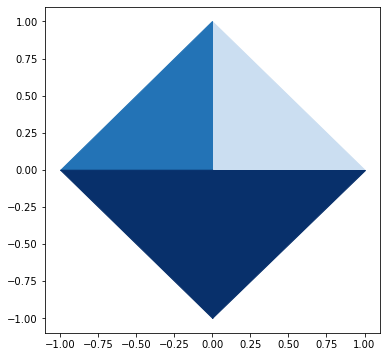

In [54]:
render(octahedron, color_map=matplotlib.cm.get_cmap('Blues'), lines=black)

In [55]:
def split(face):
    midpoints = [unit(add(face[i], face[(i+1)%len(face)])) for i in range(0,len(face))]
    triangles = [(face[i], midpoints[i], midpoints[(i-1)%len(face)]) for i in range(0,len(face))]
    return [midpoints] + triangles

def rec_split(faces, depth=0):
    if depth == 0:
        return faces
    else:
        return rec_split([new_face for face in faces for new_face in split(face)], depth-1)

# NICE SPHERE!
def sphere_approx(n):
    return rec_split(octahedron,n)

### Modified linewidth=0 in draw2d to remove the edges of each triangles

### Moved the light light=(1,2,0) to look  like a half illuminated sphere

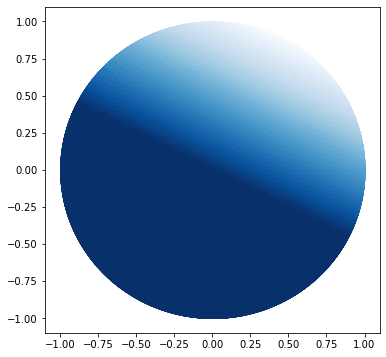

In [57]:
render(sphere_approx(6), lines='gray')